In [4]:
from molmap import model as molmodel
import molmap

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
np.random.seed(123)
tf.compat.v1.set_random_seed(123)


tmp_feature_dir = './tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)

In [5]:

mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')


In [6]:
task_name = 'PDBbind-full'

from chembench import load_data

df, induces = load_data(task_name)
if len(induces) == 1: # run 3 times
    induces = induces*3

loading dataset: PDBbind-full number of split times: 1


In [7]:
smiles_col = df.columns[0]
values_col = df.columns[1:]
Y = df[values_col].astype('float').values
Y = Y.reshape(-1, 1)


X1_name = os.path.join(tmp_feature_dir, 'X1_%s.data' % task_name)
X2_name = os.path.join(tmp_feature_dir, 'X2_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

if not os.path.exists(X2_name): 
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)
else:
    X2 = load(X2_name)

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]


In [8]:
epochs = 800
patience = 50 #early stopping

dense_layers = [256, 128, 32]
batch_size = 128
lr = 1e-4
weight_decay = 0

loss = 'mse'
monitor = 'val_loss'
dense_avf = 'relu'
last_avf = 'linear'


In [9]:
results = []

for i, split_idxs in enumerate(induces):

    train_idx, valid_idx, test_idx = split_idxs
    
    train_idx = [i for i in train_idx if i < len(df)]
    valid_idx = [i for i in valid_idx if i < len(df)]    
    test_idx = [i for i in test_idx if i < len(df)]
    
    print(len(train_idx), len(valid_idx), len(test_idx))

    trainX = (X1[train_idx], X2[train_idx])
    trainY = Y[train_idx]

    validX = (X1[valid_idx], X2[valid_idx])
    validY = Y[valid_idx]

    testX = (X1[test_idx], X2[test_idx])
    testY = Y[test_idx]            


    model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                       n_outputs=Y.shape[-1], 
                                       dense_layers=dense_layers, 
                                       dense_avf = dense_avf, 
                                       last_avf=last_avf)

    opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
    #import tensorflow_addons as tfa
    #opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = loss)
    

    if i == 0:
        performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                                   (validX, validY), 
                                                                   patience = patience, 
                                                                   criteria = monitor)
        model.fit(trainX, trainY, batch_size=batch_size, 
              epochs=epochs, verbose= 0, shuffle = True, 
              validation_data = (validX, validY), 
              callbacks=[performance]) 
    else:
        model.fit(trainX, trainY, batch_size=batch_size, 
              epochs = performance.best_epoch + 1, verbose = 1, shuffle = True, 
              validation_data = (validX, validY)) 
            
    performance.model.set_weights(model.get_weights())
    
    best_epoch = performance.best_epoch
    trainable_params = model.count_params()

    train_rmses, train_r2s = performance.evaluate(trainX, trainY)            
    valid_rmses, valid_r2s = performance.evaluate(validX, validY)            
    test_rmses, test_r2s = performance.evaluate(testX, testY)


    final_res = {
                 'task_name':task_name,            
                 'train_rmse':np.nanmean(train_rmses), 
                 'valid_rmse':np.nanmean(valid_rmses),                      
                 'test_rmse':np.nanmean(test_rmses), 

                 'train_r2':np.nanmean(train_r2s), 
                 'valid_r2':np.nanmean(valid_r2s),                      
                 'test_r2':np.nanmean(test_r2s), 

                 '# trainable params': trainable_params,
                 'best_epoch': best_epoch,
                 'batch_size':batch_size,
                 'lr': lr,
                 'weight_decay':weight_decay
                }
    results.append(final_res)
    

7904 988 988
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 0001, loss: 0.8314 - val_loss: 0.5990; rmse: 0.8533 - rmse_val: 0.7740;  r2: 0.2787 - r2_val: 0.2726                                                                                                    
epoch: 0002, loss: 0.7096 - val_loss: 0.5606; rmse: 0.8344 - rmse_val: 0.7487;  r2: 0.3266 - r2_val: 0.3158                                                                                                    
epoch: 0003, loss: 0.6763 - val_loss: 0.5547; rmse: 0.7998 - rmse_val: 0.7448;  r2: 0.3650 - r2_val: 0.3414                                                                                                    
epoch: 0004, loss: 0.6661 - val_loss: 0.5750; rmse: 0.7945 - rmse_val: 0.7583;  r2: 0.3869 - r2_val: 0.3538                                                                                                    
epoch: 0005, loss: 0.6192 - val_loss:

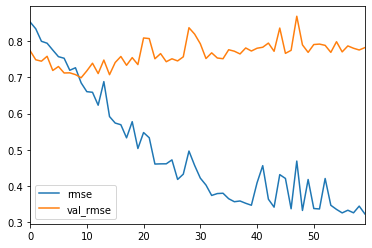

In [10]:
pd.DataFrame(performance.history)[['rmse', 'val_rmse']].plot()

In [11]:
pd.DataFrame(results).test_rmse.mean()

0.7206731481127103

In [12]:
pd.DataFrame(results).test_rmse.std()

0.004487990864246145

In [13]:
pd.DataFrame(results).to_csv('./results/%s.csv' % task_name)

In [14]:
pd.DataFrame(results)

,task_name,train_rmse,valid_rmse,test_rmse,train_r2,valid_r2,test_r2,# trainable params,best_epoch,batch_size,lr,weight_decay
0,PDBbind-full,0.684850,0.699041,0.720948,0.544711,0.402919,0.250289,803681,9,128,0.0001,0
1,PDBbind-full,0.698996,0.716491,0.725017,0.524649,0.397860,0.235890,803681,9,128,0.0001,0
2,PDBbind-full,0.675493,0.717936,0.716054,0.561555,0.391397,0.246253,803681,9,128,0.0001,0
